In [1]:
import larry
import scdiffeq as sdq
import scdiffeq_analyses as sdq_an
import pandas as pd

from typing import Tuple

import dev

/home/mvinyard/.anaconda3/envs/sdq-dev/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Load `F_obs`

In [2]:
F_obs = larry.tasks.fate_prediction.F_obs.copy()
print(F_obs.shape)
F_obs.head()

(2081, 10)


,Baso,Ccr7_DC,Eos,Erythroid,Lymphoid,Mast,Meg,Monocyte,Neutrophil,pDC
13199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13226,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13235,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Load the LARRY `adata`

In [3]:
adata = sdq.io.read_h5ad(
    "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"
)

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


### Plot the clustered `F_obs` matrix

In [4]:
fb_mtx = sdq_an.tl.LARRY_fate_prediction.OrderedFateBiasMatrix()

<Figure size 1000x1000 with 0 Axes>

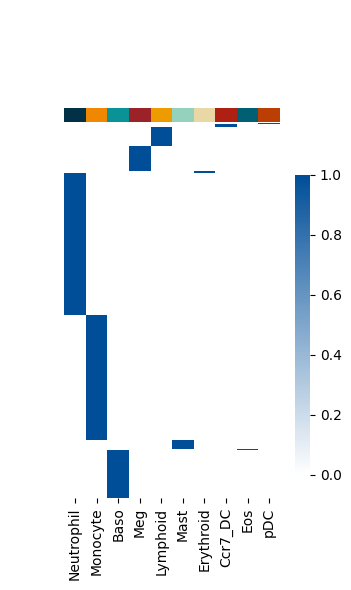

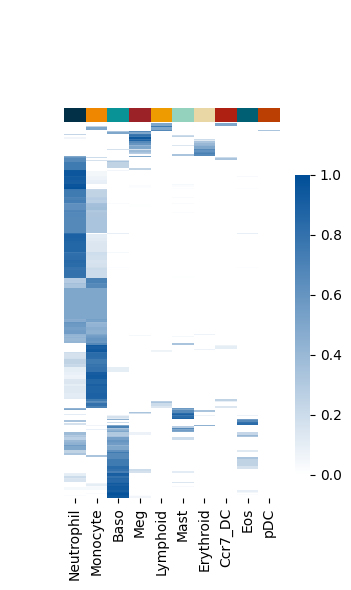

In [5]:
sdq_an.pl.LARRY_fate_prediction.plot_clustermap(
    df=fb_mtx.F_obs,
    ordered_columns=fb_mtx.clustered_fates,
    ordered_subset_idx=fb_mtx.monofate_ordered_indices,
    save_path=f"fate_plots/F_obs.clustermap.monofate.svg",
)

sdq_an.pl.LARRY_fate_prediction.plot_clustermap(
    df=fb_mtx.F_obs,
    ordered_columns=fb_mtx.clustered_fates,
    ordered_subset_idx=fb_mtx.multifate_ordered_indices,
    save_path=f"fate_plots/F_obs.clustermap.multifate.svg",
)

### Compute the baseline ratio of undifferentiated cells in observed fates

In [6]:
obs_ratio = sdq_an.tl.LARRY_fate_prediction.count_ratio_from_adata(adata=adata, F_obs=F_obs)

  0%|          | 0/2081 [00:00<?, ?it/s]

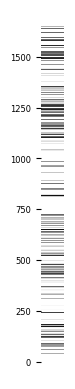

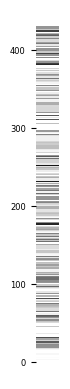

In [7]:
sdq_an.pl.LARRY_fate_prediction.plot_count_ratio(
    counts=obs_ratio,
    ordered_indices=fb_mtx.monofate_ordered_indices,
    save_path=f"./fate_plots/undiff_ratio.monofate.svg",
)
sdq_an.pl.LARRY_fate_prediction.plot_count_ratio(
    counts=obs_ratio,
    ordered_indices=fb_mtx.multifate_ordered_indices,
    save_path=f"./fate_plots/undiff_ratio.multifate.svg",
)

---

In [8]:
fb_mtx = sdq_an.tl.LARRY_fate_prediction.OrderedFateBiasMatrix()

In [9]:
F_hat_raw = pd.read_csv("/home/mvinyard/experiments/PBA_TIGON_comparison/F_hat.TIGON.csv", index_col = 0)

In [10]:
F_hat = dev.augment_columns(F_hat = F_hat_raw, F_obs = F_obs).copy()
F_hat.index = F_hat.index.astype(str)
F_hat_norm = F_hat.div(F_hat.sum(1), axis = 0).fillna(0)

<Figure size 1000x1000 with 0 Axes>

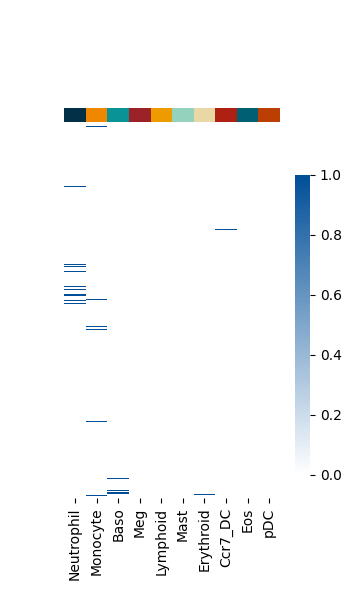

In [11]:
sdq_an.pl.LARRY_fate_prediction.plot_clustermap(
        df=F_hat_norm,
        ordered_columns=fb_mtx.clustered_fates,
        ordered_subset_idx=fb_mtx.monofate_ordered_indices,
        save_path=f"fate_plots/F_hat.clustermap.monofate.TIGON.svg",
    )

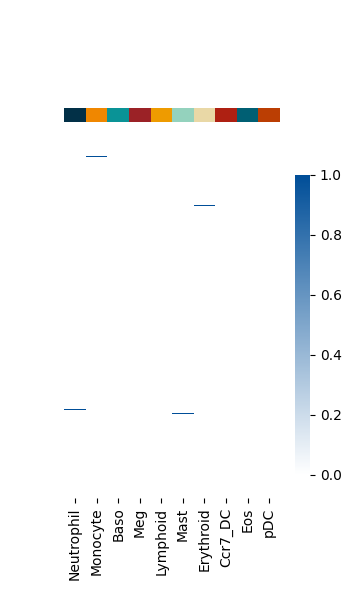

In [12]:
sdq_an.pl.LARRY_fate_prediction.plot_clustermap(
        df=F_hat_norm,
        ordered_columns=fb_mtx.clustered_fates,
        ordered_subset_idx=fb_mtx.multifate_ordered_indices,
        save_path=f"fate_plots/F_hat.clustermap.multifate.TIGON.svg",
    )

In [13]:
no_fate_pred = F_hat.sum(1) == 0
print(f"Null fate counts predicted: {no_fate_pred.sum()}")

Null fate counts predicted: 1976


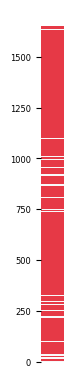

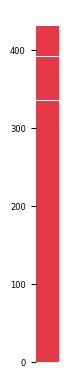

In [14]:
sdq_an.pl.LARRY_fate_prediction.plot_null_fate(
    no_fate_pred.loc[fb_mtx.monofate_ordered_indices],
    save_path = f"fate_plots/null_fate_pred.monofate.TIGON.svg",
)
sdq_an.pl.LARRY_fate_prediction.plot_null_fate(
    no_fate_pred.loc[fb_mtx.multifate_ordered_indices],
    save_path = f"fate_plots/null_fate_pred.multifate.TIGON.svg",
)

Monofate accuracy: 84/1650
Multifate accuracy: 2/431


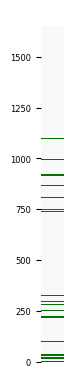

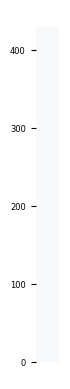

In [15]:
fate_acc = sdq_an.tl.LARRY_fate_prediction.DominantFateAccuracy(
    F_obs=F_obs,
    F_hat=F_hat,
    clustered_fates=fb_mtx.clustered_fates,
    monofate_ordered_indices=fb_mtx.monofate_ordered_indices,
    multifate_ordered_indices=fb_mtx.multifate_ordered_indices,
)
sdq_an.pl.LARRY_fate_prediction.plot_dominant_fate_accuracy(
    values=fate_acc.monofate,
    save_path=f"fate_plots/dominant_monofate_accuracy.TIGON.svg",
)
sdq_an.pl.LARRY_fate_prediction.plot_dominant_fate_accuracy(
    values=fate_acc.multifate,
    save_path=f"fate_plots/dominant_multifate_accuracy.TIGON.svg",
)

print(f"Monofate accuracy: {fate_acc.monofate.sum()}/{fate_acc.monofate.shape[0]}")
print(f"Multifate accuracy: {fate_acc.multifate.sum()}/{fate_acc.multifate.shape[0]}")

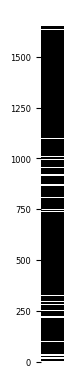

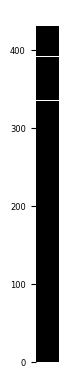

In [29]:
# undiff_ratio = sdq_an.tl.LARRY_fate_prediction.count_ratio_from_F_hat(F_hat_aug)
undiff_ratio = (4000 - F_hat.sum(1))/4000

sdq_an.pl.LARRY_fate_prediction.plot_count_ratio(
    counts = undiff_ratio,
    ordered_indices = fb_mtx.monofate_ordered_indices,
    save_path=f"fate_plots/undiff_ratio.monofate.TIGON.svg",
    dpi=250,
)
sdq_an.pl.LARRY_fate_prediction.plot_count_ratio(
    counts = undiff_ratio,
    ordered_indices = fb_mtx.multifate_ordered_indices,
    save_path=f"fate_plots/undiff_ratio.multifate.TIGON.svg",
    dpi=250,
)